In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils #A series of convenience functions to make basic image processing functions such as translation, rotation, resizing, skeletonization, displaying Matplotlib images, sorting contours, detecting edges, and much more easier with OpenCV and both Python 2.7 and Python 3.

In [21]:
img_orig = cv2.imread('./images/001.jpg')

In [22]:
cv2.namedWindow('original',cv2.WINDOW_NORMAL)
cv2.imshow('original',img_orig)
cv2.waitKey()
cv2.destroyAllWindows()

### Scanning

#### 1. Resize the image and set aspect ratio

In [23]:
 def resizer(image,width=500):
    # get widht and height
    h,w,c = image.shape
    
    height = int((h/w)* width )
    size = (width,height)
    image = cv2.resize(image,(width,height))
    return image, size

In [24]:
img_re,size = resizer(img_orig)
print(size)
cv2.imshow('Resize',img_re)
cv2.waitKey()
cv2.destroyAllWindows()

(500, 347)


#### 2. Image Processing
1. Enhance
2. Grayscale
3. Blur
4. Edge Detect
5. Morphological transform
6. Countors
7. Find Four Points


### Enhance 

In [25]:
detail = cv2.detailEnhance(img_re,sigma_s = 20, sigma_r = 0.15)
gray = cv2.cvtColor(detail,cv2.COLOR_BGR2GRAY) # GRAYSCALE IMAGE
blur = cv2.GaussianBlur(gray,(5,5),0)
# edge detect
edge_image = cv2.Canny(blur,75,200)
# morphological transform
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(edge_image,kernel,iterations=1)
closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE,kernel)

# find the contours
contours , hire = cv2.findContours(closing,
                                   cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours, key=cv2.contourArea, reverse=True)
for contour in contours:
    peri = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,0.02*peri, True)
    
    if len(approx) == 4:
        four_points = np.squeeze(approx)
        break
        
cv2.drawContours(img_re,[four_points],-1,(0,255,0),3)

# find four points for original image
multiplier = img_orig.shape[1] / size[0]
four_points_orig = four_points * multiplier
four_points_orig = four_points_orig.astype(int)

In [26]:
from imutils.perspective import four_point_transform

In [27]:
wrap_image = four_point_transform(img_orig,four_points_orig)

In [28]:
cv2.imshow('wrap',wrap_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### document scanner function

In [29]:
def document_scanner(image):

    img_re,size = resizer(image)
    detail = cv2.detailEnhance(img_re,sigma_s = 20, sigma_r = 0.15)
    gray = cv2.cvtColor(detail,cv2.COLOR_BGR2GRAY) # GRAYSCALE IMAGE
    blur = cv2.GaussianBlur(gray,(5,5),0)
    # edge detect
    edge_image = cv2.Canny(blur,75,200)
    # morphological transform
    kernel = np.ones((5,5),np.uint8)
    dilate = cv2.dilate(edge_image,kernel,iterations=1)
    closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE,kernel)

    # find the contours
    contours , hire = cv2.findContours(closing,
                                       cv2.RETR_LIST,
                                       cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        peri = cv2.arcLength(contour,True)
        approx = cv2.approxPolyDP(contour,0.02*peri, True)

        if len(approx) == 4:
            four_points = np.squeeze(approx)
            break

    cv2.drawContours(img_re,[four_points],-1,(0,255,0),3)

    # find four points for original image
    multiplier = image.shape[1] / size[0]
    four_points_orig = four_points * multiplier
    four_points_orig = four_points_orig.astype(int)

    wrap_image = four_point_transform(image,four_points_orig)
    
    return wrap_image, four_points_orig, img_re, closing

In [30]:
img = cv2.imread('./images/001.jpg')
wrpimg, points, cnt_img, edgeimg = document_scanner(img)

In [31]:
cv2.imshow('original',img)
cv2.imshow('resize',cnt_img)
cv2.imshow('edge',edgeimg)
cv2.imshow('wrap',wrpimg)
cv2.waitKey()
cv2.destroyAllWindows()

### Magic Color
### increase the brightness and contrast

In [32]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [33]:
rgb = cv2.cvtColor(wrpimg,cv2.COLOR_BGR2RGB)
magic_image = apply_brightness_contrast(rgb,120,0)
magic_image_c1 = apply_brightness_contrast(rgb,0,40)
magic_image_c2 = apply_brightness_contrast(rgb,50,40)

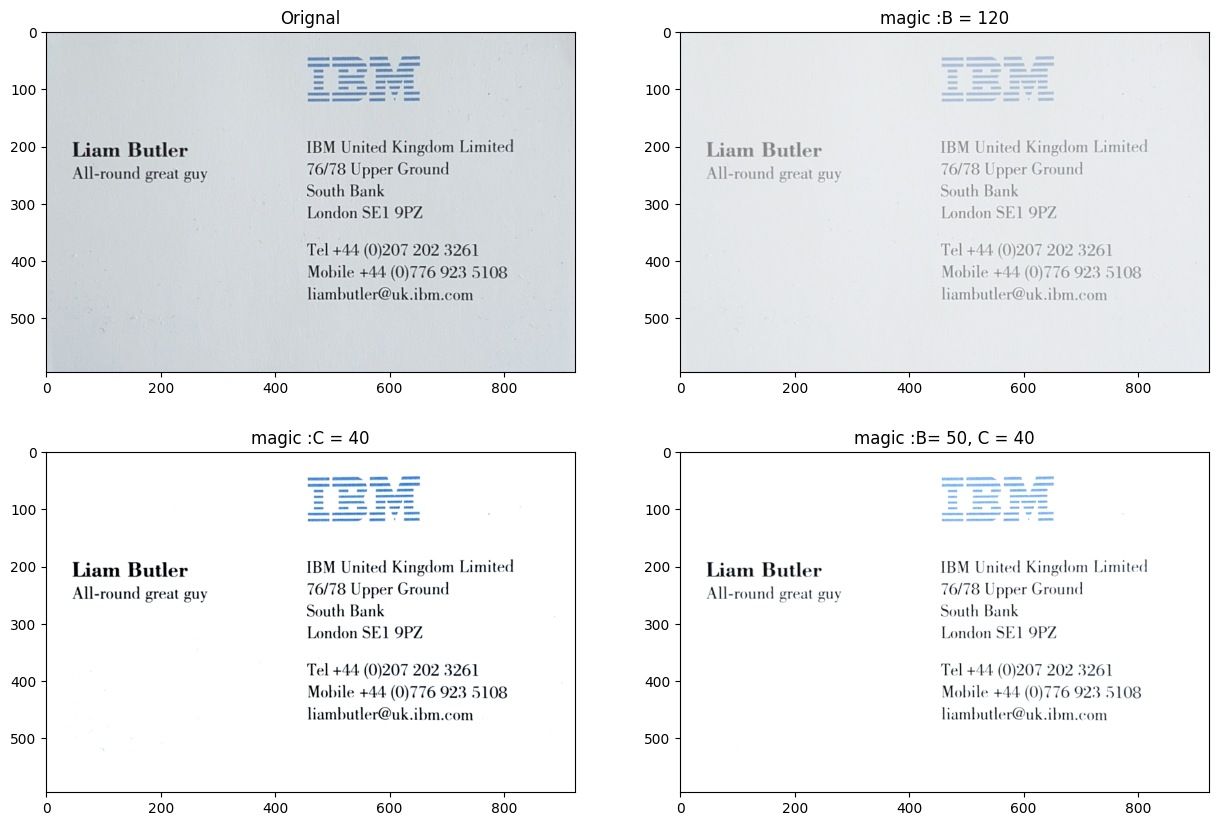

In [34]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(rgb)
plt.title('Orignal')

plt.subplot(2,2,2)
plt.imshow(magic_image)
plt.title('magic :B = 120')

plt.subplot(2,2,3)
plt.imshow(magic_image_c1)
plt.title('magic :C = 40')


plt.subplot(2,2,4)
plt.imshow(magic_image_c2)
plt.title('magic :B= 50, C = 40')

plt.show()

### Predections

In [35]:
import Predicitions as pred

In [36]:
img_bb, results = pred.getPredictions(magic_image_c2)

In [37]:
cv2.namedWindow('prediction',cv2.WINDOW_NORMAL)
cv2.imshow('prediction',img_bb)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [38]:
results

{'NAME': [],
 'ORG': ['United', 'Limited', 'Upper Ground South'],
 'DES': [],
 'PHONE': ['4402072023261', '4407769235108'],
 'EMAIL': ['liambutler@uk.ibm.com'],
 'WEB': []}